*This is just a ***lecture*** notebook - you do not have to hand this in!*

# Lecture 02 - 10.05.2022
Playing around with the combination of features for fitting a linare regression model.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from ipywidgets import interactive, widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

### Pre-Processing

In [6]:
# read data
data = pd.read_csv('student-mat.csv')

# split data
train, test = train_test_split(data, test_size=0.33)

# encode data
binary_vars = ["school", "sex", "address", "famsize", "Pstatus", "schoolsup",
               "famsup", "paid", "activities", "nursery", "higher", 
               "internet", "romantic"]
nominal_vars = ["Mjob", "Fjob", "reason", "guardian"]
class_ohe = OneHotEncoder(drop="if_binary", sparse=False)
train[binary_vars] = class_ohe.fit_transform(train.loc[:, binary_vars])
test[binary_vars] = class_ohe.transform(test.loc[:, binary_vars])
train.drop(columns=nominal_vars, inplace=True)
test.drop(columns=nominal_vars, inplace=True)

# scale data
scaler = StandardScaler()
train_scaled_array = scaler.fit_transform(train)
test_scaled_array = scaler.transform(test)
train_scaled = pd.DataFrame(train_scaled_array, columns=train.columns)
test_scaled = pd.DataFrame(test_scaled_array, columns=test.columns)

# create X and Y
target = "G3"
X_train = train_scaled.drop(columns=target)
Y_train = train_scaled[target]
X_test = test_scaled.drop(columns=target)
Y_test = test_scaled[target]

### Correlation Matrix

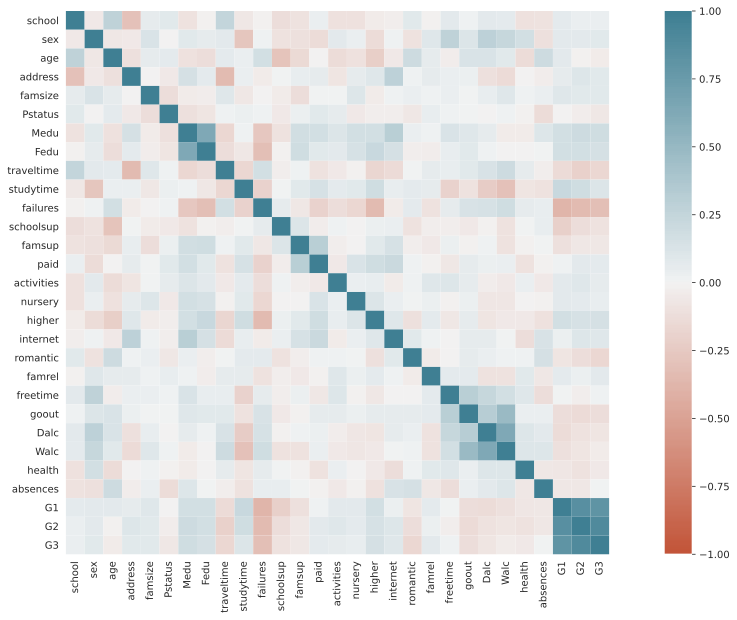

In [7]:
# Correlation matrix
corr_mat = train.corr(method='pearson')


plt.figure(figsize=(20,10))
ax = sns.heatmap(
    corr_mat, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

### Linear Regression Widget
Running the following cell will start an IPyWidget.

On the left side you can see a list of all the features that can be used for fitting a linear regression model. You can choose a feature by clicking with the mouse. To choose several features you have to hold the CTRL key.

After choosing the features the model will be fitted by hitting the `Run` button. The output will give you some metrics and visualizations.

In [8]:
features_selectmultiple = widgets.SelectMultiple(
    description="Features",
    options=X_train.columns,
    rows=25,
    disabled=False,
    layout={"width": '80%'}
)

run_button = widgets.Button(
    description='Run',
    disabled=False,
    button_style='',
    icon='check',
    layout={"width": '80%'}
)

choice_box = widgets.VBox([features_selectmultiple, run_button])

out_plot1 = widgets.Output()
out_plot2 = widgets.Output()
out_text = widgets.Output()

grid = widgets.GridBox(children=[choice_box, out_text, out_plot1, out_plot2],
            layout=widgets.Layout(
            grid_template_rows='auto auto',
            grid_template_columns='50% 50%')
)

display(grid)

def on_button_clicked(b):
    lm1 = LinearRegression()
    lm1.fit(X_train[list(features_selectmultiple.value)], Y_train)
    lm1_preds = lm1.predict(X_test[list(features_selectmultiple.value)])

    Y_test_reverted = (Y_test * scaler.scale_[-1]) + scaler.mean_[-1]
    lm1_preds_reverted = (lm1_preds * scaler.scale_[-1]) + scaler.mean_[-1]
        
    with out_plot1:
        out_plot1.clear_output(True)
               
        fg1 = sns.jointplot(x=Y_test_reverted, y=lm1_preds_reverted,xlim=(-2,22), ylim=(-2,22))
        fg1.ax_joint.set_xlabel('observed G3')
        fg1.ax_joint.set_ylabel('predicted G3')
        fg1.fig.suptitle('Reverted standardization')
        plt.tight_layout()
        plt.show()
        
    with out_plot2:
        out_plot2.clear_output(True)
        
        fg2 = sns.barplot(x=np.arange(len(lm1.coef_)), y=lm1.coef_)
        fg2.set_xlabel('Features')
        fg2.set_xticklabels(features_selectmultiple.value, rotation=90)
        fg2.set_ylabel('Coef')
        fg2.set_title("Coefficients")
        plt.show()
        
    with out_text:
        out_text.clear_output(True)
        
        print(f"Used features: \n{features_selectmultiple.value}\n\n")
        
        print(f"Intercept: \n{lm1.intercept_}\n\n")
        
        print('Reverted standardization:')
        print("RMSE :", np.sqrt(mean_squared_error(Y_test_reverted, lm1_preds_reverted)))
        print("R^2: ", r2_score(Y_test_reverted, lm1_preds_reverted))

run_button.on_click(on_button_clicked, False)

GridBox(children=(VBox(children=(SelectMultiple(description='Features', layout=Layout(width='80%'), options=('…